# Part 1: Packaging and Uploading your Algorithm for use with Amazon SageMaker

### An overview of Docker

If you're familiar with Docker already, you can skip ahead to the next section.

For many data scientists, Docker containers are a new technology. But they are not difficult and can significantly simplify the deployment of your software packages. 

Docker provides a simple way to package arbitrary code into an _image_ that is totally self-contained. Once you have an image, you can use Docker to run a _container_ based on that image. Running a container is just like running a program on the machine except that the container creates a fully self-contained environment for the program to run. Containers are isolated from each other and from the host environment, so the way your program is set up is the way it runs, no matter where you run it.

Docker is more powerful than environment managers like conda or virtualenv because (a) it is completely language independent and (b) it comprises your whole operating environment, including startup commands, and environment variable.

A Docker container is like a virtual machine, but it is much lighter weight. For example, a program running in a container can start in less than a second and many containers can run simultaneously on the same physical or virtual machine instance.

Docker uses a simple file called a `Dockerfile` to specify how the image is assembled. An example is provided below. You can build your Docker images based on Docker images built by yourself or by others, which can simplify things quite a bit.

Docker has become very popular in programming and devops communities due to its flexibility and its well-defined specification of how code can be run in its containers. It is the underpinning of many services built in the past few years, such as [Amazon ECS].

Amazon SageMaker uses Docker to allow users to train and deploy arbitrary algorithms.

In Amazon SageMaker, Docker containers are invoked in a one way for training and another, slightly different, way for hosting. The following sections outline how to build containers for the SageMaker environment.

Some helpful links:

* [Docker home page](http://www.docker.com)
* [Getting started with Docker](https://docs.docker.com/get-started/)
* [Dockerfile reference](https://docs.docker.com/engine/reference/builder/)
* [`docker run` reference](https://docs.docker.com/engine/reference/run/)

[Amazon ECS]: https://aws.amazon.com/ecs/

### How Amazon SageMaker runs your Docker container

Because you can run the same image in training or hosting, Amazon SageMaker runs your container with the argument `train` or `serve`. How your container processes this argument depends on the container. All SageMaker deep learning framework containers already cover this requirement and will trigger your defined training algorithm and inference code.

* If you specify a program as an `ENTRYPOINT` in the Dockerfile, that program will be run at startup and its first argument will be `train` or `serve`. The program can then look at that argument and decide what to do. The original `ENTRYPOINT` specified within the SageMaker PyTorch is [here](https://github.com/aws/sagemaker-pytorch-container/blob/master/docker/0.4.0/final/Dockerfile.cpu#L18).

#### Running your container during training

Currently, our SageMaker PyTorch container utilizes [console_scripts](http://python-packaging.readthedocs.io/en/latest/command-line-scripts.html#the-console-scripts-entry-point) to make use of the `train` command issued at training time. The line that gets invoked during `train` is defined within the setup.py file inside [SageMaker Containers](https://github.com/aws/sagemaker-containers/blob/master/setup.py#L48), our common SageMaker deep learning container framework. When this command is run, it will invoke the [trainer class](https://github.com/aws/sagemaker-containers/blob/master/src/sagemaker_containers/cli/train.py) to run, which will finally invoke our [PyTorch container code](https://github.com/aws/sagemaker-pytorch-container/blob/master/src/sagemaker_pytorch_container/training.py) to run your Python file.

A number of files are laid out for your use, under the `/opt/ml` directory:

    /opt/ml
    |-- input
    |   |-- config
    |   |   |-- hyperparameters.json
    |   |   `-- resourceConfig.json
    |   `-- data
    |       `-- <channel_name>
    |           `-- <input data>
    |-- model
    |   `-- <model files>
    `-- output
        `-- failure

##### The input

* `/opt/ml/input/config` contains information to control how your program runs. `hyperparameters.json` is a JSON-formatted dictionary of hyperparameter names to values. These values are always strings, so you may need to convert them. `resourceConfig.json` is a JSON-formatted file that describes the network layout used for distributed training.
* `/opt/ml/input/data/<channel_name>/` (for File mode) contains the input data for that channel. The channels are created based on the call to CreateTrainingJob but it's generally important that channels match algorithm expectations. The files for each channel are copied from S3 to this directory, preserving the tree structure indicated by the S3 key structure. 
* `/opt/ml/input/data/<channel_name>_<epoch_number>` (for Pipe mode) is the pipe for a given epoch. Epochs start at zero and go up by one each time you read them. There is no limit to the number of epochs that you can run, but you must close each pipe before reading the next epoch.

##### The output

* `/opt/ml/model/` is the directory where you write the model that your algorithm generates. Your model can be in any format that you want. It can be a single file or a whole directory tree. SageMaker packages any files in this directory into a compressed tar archive file. This file is made available at the S3 location returned in the `DescribeTrainingJob` result.
* `/opt/ml/output` is a directory where the algorithm can write a file `failure` that describes why the job failed. The contents of this file are returned in the `FailureReason` field of the `DescribeTrainingJob` result. For jobs that succeed, there is no reason to write this file as it is ignored.

### The parts of the sample container

The `container` directory has all the components you need to extend the SageMaker PyTorch CPU or GPU container to use as an sample algorithm.

    .
    |-- build_and_push.sh
    |-- Dockerfile-cpu
    |-- Dockerfile-gpu
    |-- requirements.txt
    `-- src
        `-- train.py
         -- [Python Modules]

Let's discuss each of these in turn:

* __`build_and_push.sh`__ is a script that uses the Dockerfile to build your container images and then pushes it to ECR. We invoke the commands directly later in this notebook, but you can just copy and run the script for your own algorithms.
* __`src`__ is the directory which contains our user code to be invoked.
* __`train.py`__ is the interface to SageMaker.
* __`Dockerfile-cpu`__ describes how to build your Docker container image. More details are provided below.
* __`Dockerfile-gpu`__ builds the GPU image.


### The Dockerfile

The Dockerfile describes the image that we want to build. You can think of it as describing the complete operating system installation of the system that you want to run. A Docker container running is quite a bit lighter than a full operating system, however, because it takes advantage of Linux on the host machine for the basic operations. 

We start from the SageMaker PyTorch image as the base. The base image is an ECR image, so it will have the following pattern.
* {account}.dkr.ecr.{region}.amazonaws.com/sagemaker-{framework}:{framework_version}-{processor_type}-{python_version}

Here is an explanation of each field.
1. account - AWS account ID the ECR image belongs to. Our public deep learning framework images are all under the 520713654638 account.
2. region - The region the ECR image belongs to. [Available regions](https://aws.amazon.com/about-aws/global-infrastructure/regional-product-services/).
3. framework - The deep learning framework.
4. framework_version - The version of the deep learning framework.
5. processor_type - CPU or GPU.
6. python_version - The supported version of Python.

So the SageMaker PyTorch ECR image would be:
520713654638.dkr.ecr.us-west-2.amazonaws.com/sagemaker-pytorch:0.4.0-cpu-py3

Information on supported frameworks and versions can be found in this [README](https://github.com/aws/sagemaker-python-sdk).

Next, we add the code that implements our specific algorithm to the container and set up the right environment for it to run under.

**DISCLAIMER: As of now, the support for the two environment variables below are only supported for the SageMaker Chainer (4.1.0+) and PyTorch (0.4.0+) containers.**

Finally, we need to specify two environment variables.
1. SAGEMAKER_SUBMIT_DIRECTORY - the directory within the container containing our Python script for training and inference.
2. SAGEMAKER_PROGRAM - the Python script that should be invoked for training and inference.

Let's look at the Dockerfile for this example.

### Building and registering the container

The `build-and-push.sh` builds the container image using `docker build` and push the container image to ECR using `docker push`. 

If the `gpu` argument is passed to `build-and-push.sh` the GPU Docker file is used to create the GPU instance.  Otherwise the CPU instance is created.

This code looks for an ECR repository in the account you're using and the current default region (if you're using a SageMaker notebook instance, this is the region where the notebook instance was created). If the repository doesn't exist, the script will create it. In addition, since we are using the SageMaker PyTorch image as the base, we will need to retrieve ECR credentials to pull this public image.

In [18]:
!./container/build_and_push.sh

Requesting CPU image
Login Succeeded
Login Succeeded
Sending build context to Docker daemon  178.8MB
Step 1/10 : ARG REGION=us-east-1
Step 2/10 : FROM 520713654638.dkr.ecr.$REGION.amazonaws.com/sagemaker-pytorch:1.1.0-cpu-py3
 ---> d374fb352c72
Step 3/10 : RUN pip install --upgrade pip
 ---> Using cache
 ---> d07c143c2422
Step 4/10 : COPY requirements.txt requirements.txt
 ---> Using cache
 ---> 06c9f36f59b0
Step 5/10 : RUN pip install -r requirements.txt
 ---> Using cache
 ---> 28c88069e3b5
Step 6/10 : ENV PATH="/opt/ml/code:${PATH}"
 ---> Using cache
 ---> 363b04806968
Step 7/10 : COPY /src /opt/ml/code
 ---> Using cache
 ---> 6b69c257e340
Step 8/10 : RUN chmod -R 755 /opt/ml/code
 ---> Using cache
 ---> 88a1a67c6cfd
Step 9/10 : ENV SAGEMAKER_SUBMIT_DIRECTORY /opt/ml/code
 ---> Using cache
 ---> fdd6e3fe53f9
Step 10/10 : ENV SAGEMAKER_PROGRAM train.py
 ---> Using cache
 ---> 78fcdb945cb5
Successfully built 78fcdb945cb5
Successfully tagged sagemaker-tennis-cpu:latest
Building CPU imag

## Testing your algorithm on your local machine

When you're packaging your first algorithm to use with Amazon SageMaker, you probably want to test it yourself to make sure it's working correctly. We use the [SageMaker Python SDK](https://github.com/aws/sagemaker-python-sdk) to test both locally and on SageMaker. For more examples with the SageMaker Python SDK, see [Amazon SageMaker Examples](https://github.com/awslabs/amazon-sagemaker-examples/tree/master/sagemaker-python-sdk). In order to test our algorithm, we need our dataset.

## SageMaker Python SDK Local Training
To represent our training, we use the Estimator class, which needs to be configured in five steps. 
1. IAM role - our AWS execution role
2. train_instance_count - number of instances to use for training.
3. train_instance_type - type of instance to use for training. For training locally, we specify `local`.
4. image_name - our custom PyTorch Docker image we created.
5. hyperparameters - hyperparameters we want to pass.

Let's start with setting up our IAM role. We make use of a helper function within the Python SDK. This function throw an exception if run outside of a SageMaker notebook instance, as it gets metadata from the notebook instance. If running outside, you must provide an IAM role with proper access stated above in [Permissions](#Permissions).

### Setup Notebook for local execution

In [19]:
!/bin/bash ./utils/setup.sh

The user has root access.
SageMaker instance route table setup is ok. We are good to go.
SageMaker instance routing for Docker is ok. We are good to go!


### Traing the Reinforcement Learning Model Locally
Note we are only training for 200 iterations, which is too few to see any increase in the average score.  We are a purely checking for mechanical errors.

In [20]:
from sagemaker.estimator import Estimator
from sagemaker import get_execution_role

role = get_execution_role()
estimator = Estimator(role=role,
                      train_instance_count=1,
                      train_instance_type='local',
                      image_name='sagemaker-tennis-cpu:latest',
                      hyperparameters={'epochs': 200})

estimator.fit()

Creating tmp7fg3myn1_algo-1-i5b5u_1 ... 
Attaching to tmp7fg3myn1_algo-1-i5b5u_12mdone
algo-1-i5b5u_1  | 2020-06-26 16:41:38,807 sagemaker-containers INFO     Imported framework sagemaker_pytorch_container.training
algo-1-i5b5u_1  | 2020-06-26 16:41:38,811 sagemaker-containers INFO     No GPUs detected (normal if no gpus installed)
algo-1-i5b5u_1  | 2020-06-26 16:41:38,824 sagemaker_pytorch_container.training INFO     Block until all host DNS lookups succeed.
algo-1-i5b5u_1  | 2020-06-26 16:41:38,825 sagemaker_pytorch_container.training INFO     Invoking user training script.
algo-1-i5b5u_1  | 2020-06-26 16:41:38,825 sagemaker-containers INFO     Module train does not provide a setup.py. 
algo-1-i5b5u_1  | Generating setup.py
algo-1-i5b5u_1  | 2020-06-26 16:41:38,826 sagemaker-containers INFO     Generating setup.cfg
algo-1-i5b5u_1  | 2020-06-26 16:41:38,826 sagemaker-containers INFO     Generating MANIFEST.in
algo-1-i5b5u_1  | 2020-06-26 16:41:38,826 sagemaker-containers INFO     Inst

Failed to delete: /tmp/tmp7fg3myn1/algo-1-i5b5u Please remove it manually.


===== Job Complete =====


## Training on SageMaker
Training a model on SageMaker with the Python SDK is done in a way that is similar to the way we trained it locally. This is done by changing our train_instance_type from `local` to one of our [supported EC2 instance types](https://aws.amazon.com/sagemaker/pricing/instance-types/).

### Locate the ECR image just built and pushed

In [21]:
import boto3

client = boto3.client('sts')
account = client.get_caller_identity()['Account']
region = boto3.Session().region_name
ecr_image = '{}.dkr.ecr.{}.amazonaws.com/sagemaker-tennis-cpu:latest'.format(account, region)

print(ecr_image)

031118886020.dkr.ecr.us-east-1.amazonaws.com/sagemaker-tennis-cpu:latest


### Submit the training job

In [22]:
from sagemaker.estimator import Estimator
estimator = Estimator(role=role,
                      train_instance_count=1,
                      train_instance_type='ml.m4.xlarge',
                      image_name=ecr_image,
                      hyperparameters={'epochs': 200})
estimator.fit()

2020-06-26 16:43:10 Starting - Starting the training job...
2020-06-26 16:43:12 Starting - Launching requested ML instances.........
2020-06-26 16:44:54 Starting - Preparing the instances for training......
2020-06-26 16:45:59 Downloading - Downloading input data
2020-06-26 16:45:59 Training - Downloading the training image......
2020-06-26 16:47:06 Training - Training image download completed. Training in progress..bash: cannot set terminal process group (-1): Inappropriate ioctl for device
bash: no job control in this shell
2020-06-26 16:47:07,828 sagemaker-containers INFO     Imported framework sagemaker_pytorch_container.training
2020-06-26 16:47:07,830 sagemaker-containers INFO     No GPUs detected (normal if no gpus installed)
2020-06-26 16:47:07,843 sagemaker_pytorch_container.training INFO     Block until all host DNS lookups succeed.
2020-06-26 16:47:10,883 sagemaker_pytorch_container.training INFO     Invoking user training script.
2020-06-26 16:47:10,884 sagemaker-containers

### Get the results

#### Get the bucket name

In [23]:
from sagemaker.session import Session

sagemaker_session = Session()
bucket = sagemaker_session.default_bucket()
job_name = estimator._current_job_name
print(bucket)
print(job_name)

sagemaker-us-east-1-031118886020
sagemaker-tennis-cpu-2020-06-26-16-43-10-008


#### Copy and unpack the result archive

In [24]:
import shutil

s3 = boto3.resource('s3')
key = '{}/output/output.tar.gz'.format(estimator._current_job_name)
print(key)
s3.Bucket(bucket).download_file(key, 'output.tar.gz')
shutil.unpack_archive('output.tar.gz')

sagemaker-tennis-cpu-2020-06-26-16-43-10-008/output/output.tar.gz


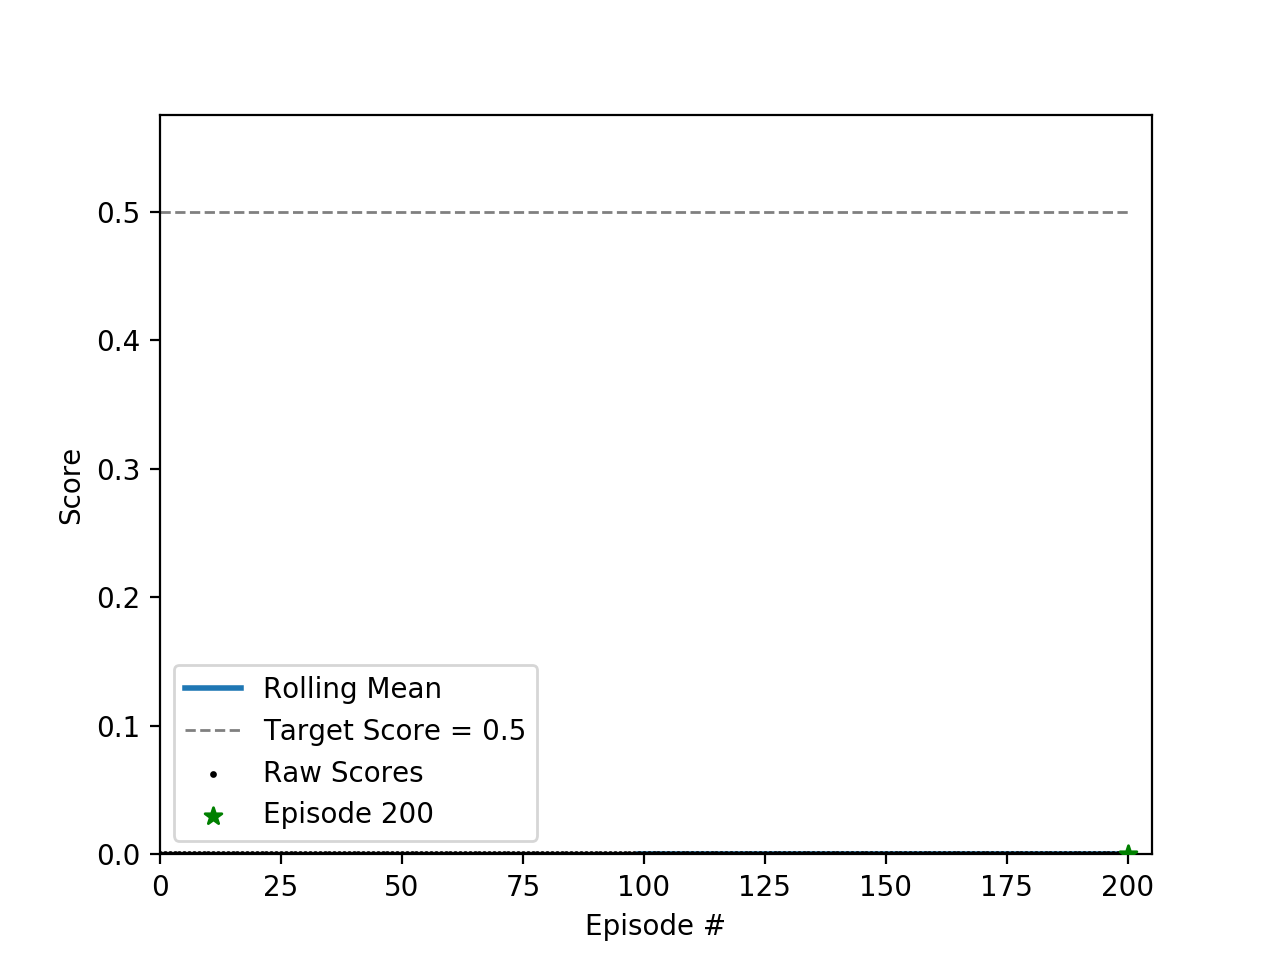

In [25]:
from IPython.display import Image
Image(filename='scores.png') 

As expected the above image isn't very interesting since we only ran for 200 iterations.  Here is the same result when we ran for 2000.
![scores](scores-initial.png)

# Reference
- [SageMaker Example:  Extending PyTorch Container](https://github.com/awslabs/amazon-sagemaker-examples/tree/master/advanced_functionality/pytorch_extending_our_containers)
- [How Amazon SageMaker interacts with your Docker container for training](https://docs.aws.amazon.com/sagemaker/latest/dg/your-algorithms-training-algo.html)
- [SageMaker Python SDK](https://github.com/aws/sagemaker-python-sdk)
- [Dockerfile](https://docs.docker.com/engine/reference/builder/)
- [scikit-bring-your-own](https://github.com/awslabs/amazon-sagemaker-examples/blob/master/advanced_functionality/scikit_bring_your_own/scikit_bring_your_own.ipynb)
- [SageMaker PyTorch container](https://github.com/aws/sagemaker-pytorch-container)